In [1]:
# import pandas as pd
import cudf as pd
from tqdm.auto import tqdm
tqdm.pandas()

In [2]:
def import_labelled_data(path="data/labelled/data.json"):
    data = pd.read_json(path, encoding="latin-1")
    return data


print("Loading data...")

data = import_labelled_data(
    path="../../data/level-0.5/data.json"
)

print("Data loaded.")


# data = data.sample(2500)

data = data.sample(frac=1).reset_index(drop=True)

data.info()
data.head()

Loading data...


/workspace/GreyLit/venv/lib/python3.10/site-packages/cudf/io/json.py:108: UserWarning: Using CPU via Pandas to read JSON dataset, this may be GPU accelerated in the future
  warnings.warn(


Data loaded.
<class 'cudf.core.dataframe.DataFrame'>
RangeIndex: 19284 entries, 0 to 19283
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   url           19284 non-null  object
 1   text          19284 non-null  object
 2   relevance     19284 non-null  object
 3   multiclasses  19284 non-null  list
dtypes: list(1), object(3)
memory usage: 1.3+ GB


,url,text,relevance,multiclasses
0,https://www.wetlands.org/publications/global-o...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,relevant,[Birds]
1,https://www.osinergmin.gob.pe/seccion/centro_d...,Guía para la ade en el Decreto S establecidas ...,irrelevant,[]
2,https://www.bantaykita.ph/uploads/2/9/9/2/2992...,subnational primer: caraga region transparency...,irrelevant,[]
3,https://vamaurienne.ovh/wp-content/uploads/201...,N° 610 SÉNAT SESSION EXTRAORDINAIRE DE 2014-20...,irrelevant,[]
4,http://ftpmirror.your.org/pub/misc/bitsavers/p...,LIQUID INK ACCESSORY KITS BALLPOINT PEN ACCESS...,irrelevant,[]


In [3]:
def train_test_split(x, y=None, test_size=0.2,shuffle=False):
    if shuffle:
        x = x.sample(frac=1).reset_index(drop=True)
    split = int(len(x) * (1 - test_size))
    xTrain, xTest = x.iloc[:split], x.iloc[split:]
    if y is not None:
        yTrain, yTest = y.iloc[:split], y.iloc[split:]
        return xTrain, xTest, yTrain, yTest
    return xTrain, xTest


trainData, testData = train_test_split(data, test_size=0.2) # already shuffled above

In [4]:
trainData.head()

,url,text,relevance,multiclasses
0,https://www.wetlands.org/publications/global-o...,\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n...,relevant,[Birds]
1,https://www.osinergmin.gob.pe/seccion/centro_d...,Guía para la ade en el Decreto S establecidas ...,irrelevant,[]
2,https://www.bantaykita.ph/uploads/2/9/9/2/2992...,subnational primer: caraga region transparency...,irrelevant,[]
3,https://vamaurienne.ovh/wp-content/uploads/201...,N° 610 SÉNAT SESSION EXTRAORDINAIRE DE 2014-20...,irrelevant,[]
4,http://ftpmirror.your.org/pub/misc/bitsavers/p...,LIQUID INK ACCESSORY KITS BALLPOINT PEN ACCESS...,irrelevant,[]


In [5]:
from cuML_LogisticRegressionClassifier import LogisticRegressionClassifier

# Vectorization on 2500 articles takes roughly 1m 7s
# Training is instant

print('Estimated time to train on full dataset: ', 67 / 2500 * len(data), ' seconds')

# 1min 0.9s for all 19284 articles

logistic = LogisticRegressionClassifier()
logistic.train(trainData)

Estimated time to train on full dataset:  516.8112  seconds
Vectorizing complete.
Training complete.


In [6]:
def eval(classifier):
    predYBools, predYProbabilities = classifier.predict_threshold(testData, threshold=0.5)
    trueYInts = (testData['relevance']=='relevant').astype('int32').to_numpy()
    predYBools = predYBools.get()
    predYProbabilities = predYProbabilities.get()

    return trueYInts, predYBools, predYProbabilities

print('Estimated articles processed per second: ', 3857 / 51)
print(f'Estimated time to predict on {len(testData)} articles: ', 51 / 3857 * len(testData), ' seconds')

Estimated articles processed per second:  75.62745098039215
Estimated time to predict on 3857 articles:  51.0  seconds


In [7]:
# 1m 1s for 2500 articles

trueYInts, predYBools, predYProbabilities = eval(logistic)


#### Switch back to Pandas and Numpy below
The bulk of computation is in training and evaluation; we can do metrics on CPU.

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score

def calculate_metrics(trueYInts, predYBools, predYProbabilities):
    return {
            "accuracy": accuracy_score(trueYInts, predYBools),
            "f1": f1_score(trueYInts, predYBools, average='macro',zero_division=0),
            "precision": precision_score(trueYInts, predYBools, average='macro',zero_division=0),
            "confusion_matrix": confusion_matrix(trueYInts, predYBools),
            "predictions": logistic.boolPredictionsToLabels(predYBools.astype('bool').astype(f'<U{len("irrelevant")}')),
            "probabilities": predYProbabilities[:,1]
        }

# need the f'<U{len("irrelevant")}' to ensure the strings don't get
# truncated to the same length as 'False'
# so we set the max length to the length of 'irrelevant'

def format_output(results):
    print(f"Accuracy: {results['accuracy']} \t F1: {results['f1']} \t Precision: {results['precision']} \t")
    print("\n\n")

In [25]:
results = calculate_metrics(trueYInts, predYBools.astype('int32'), predYProbabilities)

format_output(results)

Accuracy: 0.9929997407311382 	 F1: 0.9929493716830533 	 Precision: 0.9932437888543788 	





In [26]:
testData = testData.to_pandas()

AttributeError: 'DataFrame' object has no attribute 'to_pandas'

In [27]:
testData['predictions'] = results['predictions']
testData['score'] = results['probabilities']

In [34]:
testData.info()
testData.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3857 entries, 15427 to 19283
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   url           3857 non-null   object 
 1   text          3857 non-null   object 
 2   relevance     3857 non-null   object 
 3   multiclasses  3857 non-null   object 
 4   predictions   3857 non-null   object 
 5   score         3857 non-null   float64
dtypes: float64(1), object(5)
memory usage: 180.9+ KB


,url,text,relevance,multiclasses,predictions,score
15427,https://vamaurienne.ovh/wp-content/uploads/201...,Santé environnement Impacts de l’exposition ch...,irrelevant,[],irrelevant,0.010854
15428,https://budget.finance.go.ug/sites/default/fil...,LG Draft Budget Estimates 2024/25 VOTE: 844 Ka...,irrelevant,[],irrelevant,0.011687
15429,https://www.conservationevidence.com/individua...,"A replicated, site comparison study in 1992–20...",relevant,"[Fish, Marine]",relevant,0.995776
15430,https://www.conservationevidence.com/individua...,A 2004 review (Nicoll et al. 2004) of the same...,relevant,[Birds],relevant,0.986032
15431,https://www.wusv.org/fileadmin/Documents/Veran...,Global Dog deutsche schäferhunde - pastor alem...,irrelevant,[],irrelevant,0.030982


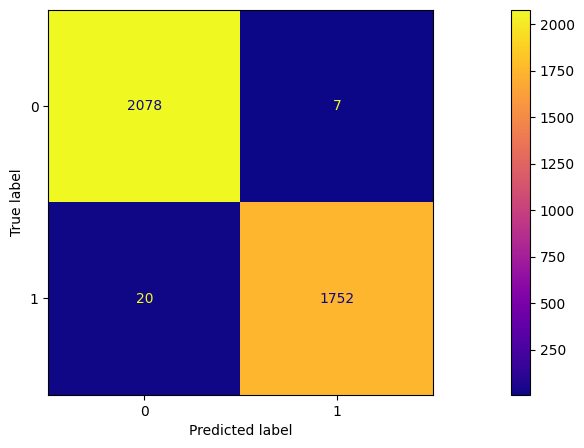

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axs = plt.subplots(1, 1, figsize=(20, 5))


confusion = confusion_matrix(testData['relevance'], testData['predictions'])
disp = ConfusionMatrixDisplay(confusion_matrix=confusion)
disp.plot(ax=axs, cmap='plasma')

plt.show()



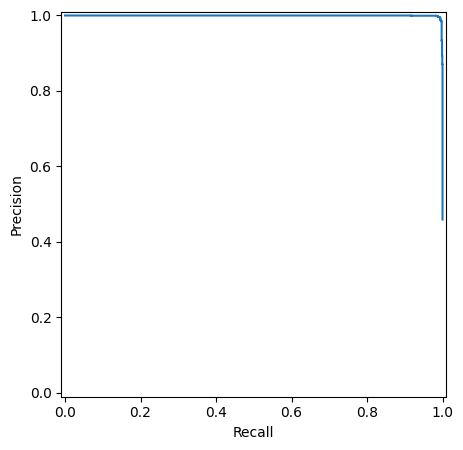

In [31]:
from sklearn.metrics import precision_recall_curve, PrecisionRecallDisplay

precision, recall, thresholds = precision_recall_curve(trueYInts, predYProbabilities[:,1])

fig, axs = plt.subplots(1, 1, figsize=(20, 5))

disp = PrecisionRecallDisplay(precision=precision, recall=recall)
disp.plot(ax=axs)

plt.show()


In [32]:
# save logistic regression model

import pickle
import os

if len(data) <= 15000:
    path = 'models/dev/LogisticRegression.pkl'
else:
    path = 'models/LogisticRegression.pkl'

with open(path, 'wb') as f:
    pickle.dump(logistic, f)

